In [ ]:
!pip install livelossplot
!pip install tensorflow==2.1

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 3.9MB 47.3MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 450kB 43.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=cd12276e3aa4d9fb7378b992654ff52ea33c23f1eba6f0caef4dcebaaa3e1e42
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tens

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
cp 'Selected.zip' '/content'

In [ ]:
cp 'segmenter_weights.h5' '/content'

In [ ]:
cd '/content'

/content


In [ ]:
!unzip Selected.zip

Archive:  Selected.zip
   creating: SelectedSGTs/
  inflating: SelectedSGTs/Sp_D_CRN_A_ani0036_ani0066_0372_gt.png  
  inflating: SelectedSGTs/Sp_D_NNN_A_ani0028_pla0007_0284_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_arc0096_cha0025_0490_gt.png  
  inflating: SelectedSGTs/Sp_D_NNN_A_art0088_art0092_0108_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_pla0085_cha0043_0495_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_art0031_ani0100_0432_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_ani0081_ani0088_0430_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_art0079_ani0065_0420_gt.png  
  inflating: SelectedSGTs/Sp_D_CNN_A_sec0012_ani0007_0275_gt.png  
  inflating: SelectedSGTs/Sp_D_NNN_A_arc0078_arc0064_0106_gt.png  
  inflating: SelectedSGTs/Sp_D_CRN_A_art0042_sec0086_0379_gt.png  
  inflating: SelectedSGTs/Sp_D_CNN_A_ani0049_ani0084_0266_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_art0036_art0053_0473_gt.png  
  inflating: SelectedSGTs/Sp_D_NRN_A_sec0021_cha0086_0502_gt.png  
  inflating:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Input, UpSampling2D, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
import os
from PIL import Image, ImageChops, ImageEnhance

In [ ]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    ELA_filename = 'tempela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

In [ ]:
ls

gdrive/       segmenter_weights.h5  SelectedSpliced/
sample_data/  SelectedSGTs/         Selected.zip


In [ ]:
import os
from PIL import Image, ImageOps

splicedGT=sorted(os.listdir('SelectedSGTs'))
splicedIMG=sorted(os.listdir('SelectedSpliced'))

In [ ]:
mkdir SGTResized

In [ ]:
mkdir SplicedResized

In [ ]:
mkdir ELAs

In [ ]:
ls

ELAs/    sample_data/   SelectedSpliced/  SGTResized/
gdrive/  SelectedSGTs/  Selected.zip      SplicedResized/


In [ ]:
#rm -r 'SplicedResized' 'SGTResized' 'ELAs'

#### ELA - Mask

In [ ]:
for i in splicedGT:
  ImageOps.grayscale(Image.open('SelectedSGTs/'+str(i)).resize((256,256))).save('SGTResized/'+str(i))
  
for i in splicedIMG:
  convert_to_ela_image('SelectedSpliced/'+str(i), 90).resize((256,256)).save('ELAs/'+str(i))

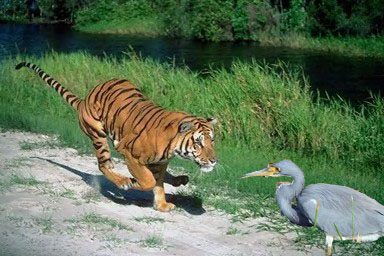

In [ ]:
Image.open('SelectedSpliced/Sp_D_CRN_A_ani0036_ani0066_0372.jpg')

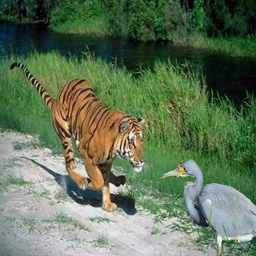

In [ ]:
Image.open('SelectedSpliced/Sp_D_CRN_A_ani0036_ani0066_0372.jpg').resize((256,256))

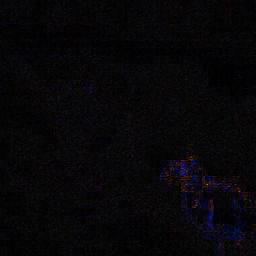

In [ ]:
Image.open('ELAs/Sp_D_CRN_A_ani0036_ani0066_0372.jpg')

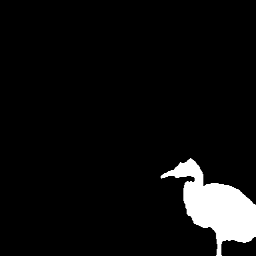

In [ ]:
Image.open('SGTResized/Sp_D_CRN_A_ani0036_ani0066_0372_gt.png')

### Data Prep

In [ ]:
X = []
Y = []

#### ELA Threshold - Mask

In [ ]:
def process(img):
    img=img.getchannel('B')
    return img

def thresholdMask(img):
    imgarr=np.array(img)
    thres=92
    arr=[[0]*256]*256
    masked=np.array(arr)
    for i in range(256):
        for j in range(256):
            if imgarr[i][j]>thres:
                masked[i][j]=1
    return masked

In [ ]:
for i in splicedIMG:
  img=process(Image.open('ELAs/'+str(i)))
  X.append(np.array(img)/np.max(img))

for i in splicedGT:
  lbl=Image.open('SGTResized/'+str(i))
  Y.append(np.array(lbl)/np.max(lbl))

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X.shape

(202, 256, 256)

In [ ]:
Y.shape

(202, 256, 256)

In [ ]:
X = X.reshape(-1, 256,256, 1)
Y = Y.reshape(-1, 256,256, 1)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

In [ ]:
X_train.shape

(161, 256, 256, 1)

In [ ]:
X_val.shape

(41, 256, 256, 1)

###Segmenter

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same', 
                 activation ='relu', input_shape = (256,256,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())

model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())

model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())

model.add(UpSampling2D(size = (2,2)))
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same', 
                 activation ='relu', input_shape = (256,256,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 1, kernel_size = (1,1), activation = 'sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization_32 (Batc (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
batch_normalization_33 (Batc (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_34 (Batc (None, 128, 128, 32)     

In [ ]:
model.compile(optimizer = Adam(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model.load_weights('segmenter_weights.h5')

In [ ]:
model_checkpoint = ModelCheckpoint('segmenter_weights.h5', monitor='loss',verbose=1, save_best_only=True)

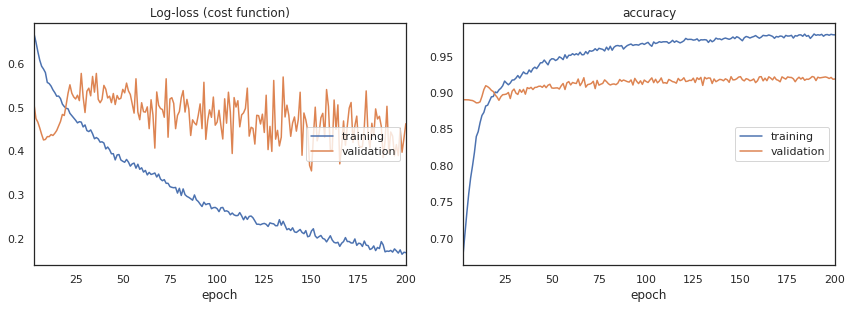

Log-loss (cost function):
training   (min:    0.165, max:    0.763, cur:    0.169)
validation (min:    0.355, max:    0.630, cur:    0.463)

accuracy:
training   (min:    0.583, max:    0.981, cur:    0.979)
validation (min:    0.886, max:    0.922, cur:    0.919)

Epoch 00200: val_accuracy did not improve from 0.92235
161/161 [==============================] - 3s 18ms/sample - loss: 0.1685 - accuracy: 0.9795 - val_loss: 0.4626 - val_accuracy: 0.9189


In [ ]:
model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=4, epochs=200, verbose=1, callbacks=[PlotLossesCallback(),model_checkpoint])

In [ ]:
cp 'segmenter_weights.h5' '/content/gdrive/My Drive/Colab Notebooks/segmenter_weights.h5'

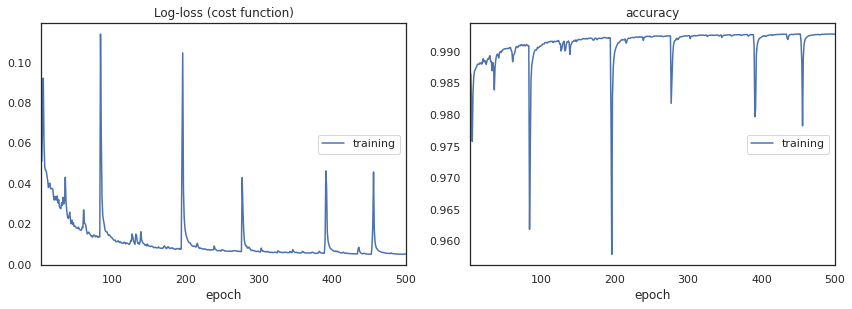

Log-loss (cost function):
training   (min:    0.005, max:    0.114, cur:    0.005)

accuracy:
training   (min:    0.958, max:    0.993, cur:    0.993)

Epoch 00500: loss did not improve from 0.00498
202/202 [==============================] - 3s 16ms/sample - loss: 0.0051 - accuracy: 0.9928


In [ ]:
model.fit(X, Y, batch_size=4, epochs=500, verbose=1, callbacks=[PlotLossesCallback(),model_checkpoint])

### Testing

In [ ]:
test=np.array(convert_to_ela_image('SelectedSpliced/Sp_D_CRN_A_ani0036_ani0066_0372.jpg', 90).resize((256,256))) / 255.0

In [ ]:
n=1

In [ ]:
testGT=Y[n].reshape(256,256)

In [ ]:
test=X[n].reshape(-1,256,256,1)

In [ ]:
result=model.predict(test)

In [ ]:
result=result.reshape(256,256)

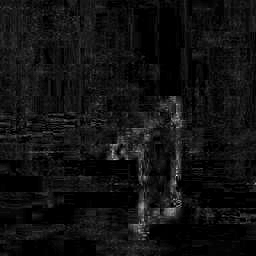

In [ ]:
Image.fromarray((test*255).reshape(256,256).astype('uint8'))

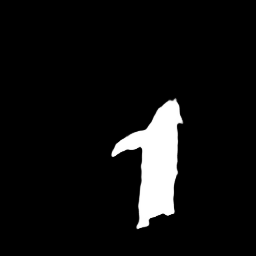

In [ ]:
Image.fromarray((result*255).astype('uint8'))

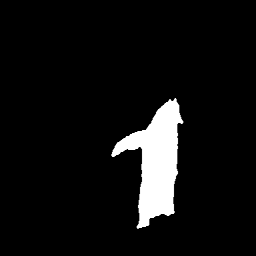

In [ ]:
Image.fromarray((testGT*255).astype('uint8'))

In [ ]:
from math import log10, sqrt

def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [ ]:
PSNR(testGT,test.reshape(256,256))

60.79815545896304